## Ensemble Methods — Bagging, Random Forests, and Boosting

This notebook walks through an end-to-end supervised learning pipeline with Ensemble Methods:
	•	Data Exploration: load, inspect, visualize
	•	Preprocessing: split, (optional) imputation
	•	Modeling: from-scratch Bagging (+ sklearn RandomForest, AdaBoost, GradientBoosting)
	•	Evaluation: accuracy, confusion matrix, classification report, ROC-AUC, ROC curves, feature importances
	•	Tuning: small GridSearchCV for RandomForest/GradientBoosting

Concepts:
	•	Bagging averages/votes across many high-variance learners trained on bootstrap samples.
	•	Random Forest = Bagging with decision trees + random feature subspacing per split.
	•	Boosting fits learners sequentially, focusing on previously misclassified points (AdaBoost) or optimizing a differentiable loss (Gradient Boosting).

## Setup

We’ll use the Breast Cancer Wisconsin dataset (binary classification). Ensembles don’t require feature scaling; we include imputation for robustness.

In [1]:
# Imports & reproducibility
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Optional, Tuple, Union, List, Dict
from IPython.display import display

# sklearn utilities
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

# Optional viz
try:
    import seaborn as sns
except Exception:
    sns = None

np.random.seed(42)
plt.rcParams["figure.figsize"] = (6.5, 4.0)

## Data Exploration

We’ll load the dataset, examine shapes, summary statistics, and class balance. Optional: quick correlations heatmap.

Shape: (569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000



Class counts (0=malignant, 1=benign):


target
1    357
0    212
Name: count, dtype: int64

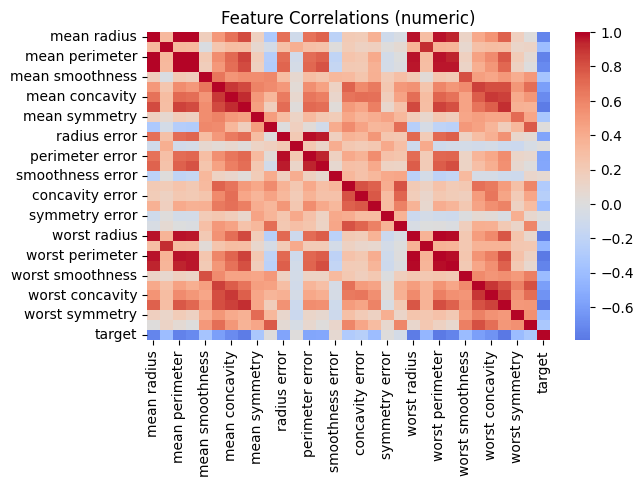

In [2]:
# Load Breast Cancer dataset
cancer = load_breast_cancer(as_frame=True)
X: pd.DataFrame = cancer.data.copy()
y: pd.Series = pd.Series(cancer.target, name="target")  # 0=malignant, 1=benign

df = X.copy()
df["target"] = y

print("Shape:", df.shape)
display(df.head())
display(df.describe())

print("\nClass counts (0=malignant, 1=benign):")
display(y.value_counts())

# Optional correlations heatmap (may be dense)
if sns is not None:
    try:
        corr = df.corr(numeric_only=True)
        sns.heatmap(corr, cmap="coolwarm", center=0)
        plt.title("Feature Correlations (numeric)")
        plt.show()
    except Exception as e:
        print("Skipping heatmap:", e)
else:
    print("Seaborn not installed; skipping heatmap.")

## Preprocessing
	•	Stratified train/test split to preserve class proportions
	•	Trees/ensembles don’t need scaling; we’ll keep a median imputer in each pipeline for generality.

In [3]:
# Train/Test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)
print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Train class balance:\n", y_train.value_counts(normalize=True))

Train shape: (426, 30)  Test shape: (143, 30)
Train class balance:
 target
1    0.626761
0    0.373239
Name: proportion, dtype: float64


## Modeling

We’ll train four models:
	1.	From-scratch Bagging classifier (simple, pedagogical) using decision trees as base learners
	2.	RandomForestClassifier (bagging + random subspace)
	3.	AdaBoostClassifier (boosting with exponential loss)
	4.	GradientBoostingClassifier (boosting with differentiable loss)

We’ll also do a small GridSearchCV for RandomForest and GradientBoosting.

In [4]:
class SimpleBaggingClassifier:
    """
    A minimal Bagging classifier using a base estimator (default: DecisionTreeClassifier).
    - Fits `n_estimators` learners on bootstrap samples (rows) and optional feature subsamples (columns).
    - Aggregates by probability averaging (then argmax).
    - Computes an OOB accuracy if bootstrap=True.
    NOTE: This is for teaching; for production, use sklearn.ensemble.BaggingClassifier.
    """
    def __init__(
        self,
        base_estimator: Optional[DecisionTreeClassifier] = None,
        n_estimators: int = 50,
        max_samples: float = 0.8,     # fraction of rows per bootstrap sample
        max_features: float = 1.0,    # fraction of columns per estimator
        bootstrap: bool = True,
        random_state: Optional[int] = 42,
    ):
        self.base_estimator = base_estimator or DecisionTreeClassifier(
            max_depth=3, random_state=0
        )
        self.n_estimators = int(n_estimators)
        self.max_samples = float(max_samples)
        self.max_features = float(max_features)
        self.bootstrap = bool(bootstrap)
        self.random_state = random_state

        self.estimators_: List[DecisionTreeClassifier] = []
        self.feature_indices_: List[np.ndarray] = []
        self.classes_: Optional[np.ndarray] = None
        self.oob_score_: Optional[float] = None

    def fit(self, X: Union[pd.DataFrame, np.ndarray], y: Union[pd.Series, np.ndarray]):
        X = np.asarray(X)
        y = np.asarray(y)
        n, d = X.shape
        rng = np.random.RandomState(self.random_state)

        self.classes_ = np.unique(y)
        self.estimators_.clear()
        self.feature_indices_.clear()

        # Track in-bag indices for OOB score
        inbag_masks = []

        n_rows = max(1, int(round(self.max_samples * n)))
        n_cols = max(1, int(round(self.max_features * d)))

        for i in range(self.n_estimators):
            # sample rows
            if self.bootstrap:
                row_idx = rng.randint(0, n, size=n_rows)  # with replacement
            else:
                row_idx = rng.choice(np.arange(n), size=n_rows, replace=False)

            # sample columns
            feat_idx = rng.choice(np.arange(d), size=n_cols, replace=False)

            est = self._fresh_estimator(i)
            est.fit(X[row_idx][:, feat_idx], y[row_idx])

            self.estimators_.append(est)
            self.feature_indices_.append(feat_idx)

            mask = np.zeros(n, dtype=bool)
            mask[row_idx] = True
            inbag_masks.append(mask)

        # Compute OOB score (if any OOB per sample exists)
        if self.bootstrap:
            votes_sum = np.zeros((n, len(self.classes_)), dtype=float)
            votes_cnt = np.zeros(n, dtype=int)

            class_to_pos = {c: j for j, c in enumerate(self.classes_)}
            for est, feat_idx, inbag in zip(self.estimators_, self.feature_indices_, inbag_masks):
                oob_idx = np.where(~inbag)[0]
                if oob_idx.size == 0:
                    continue
                proba = self._predict_proba_with_est(est, X[oob_idx][:, feat_idx], class_to_pos)
                votes_sum[oob_idx] += proba
                votes_cnt[oob_idx] += 1

            usable = votes_cnt > 0
            if usable.any():
                y_oob_pred = self.classes_[np.argmax(votes_sum[usable] / votes_cnt[usable, None], axis=1)]
                self.oob_score_ = accuracy_score(y[usable], y_oob_pred)
            else:
                self.oob_score_ = None
        else:
            self.oob_score_ = None

        return self

    def predict(self, X: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        proba = self.predict_proba(X)
        return self.classes_[np.argmax(proba, axis=1)]

    def predict_proba(self, X: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        X = np.asarray(X)
        n = X.shape[0]
        proba_sum = np.zeros((n, len(self.classes_)), dtype=float)
        class_to_pos = {c: j for j, c in enumerate(self.classes_)}

        for est, feat_idx in zip(self.estimators_, self.feature_indices_):
            proba_sum += self._predict_proba_with_est(est, X[:, feat_idx], class_to_pos)

        return proba_sum / float(self.n_estimators)

    # ---- helpers ----
    def _fresh_estimator(self, i: int) -> DecisionTreeClassifier:
        # Create a new base estimator per iteration with a different random_state for diversity
        rs = None if self.base_estimator.random_state is None else (self.base_estimator.random_state + i + 1)
        est = DecisionTreeClassifier(
            criterion=getattr(self.base_estimator, "criterion", "gini"),
            max_depth=self.base_estimator.max_depth,
            min_samples_leaf=self.base_estimator.min_samples_leaf if hasattr(self.base_estimator, "min_samples_leaf") else 1,
            random_state=rs,
        )
        return est

    def _predict_proba_with_est(
        self,
        est: DecisionTreeClassifier,
        X_sub: np.ndarray,
        class_to_pos: Dict[Union[int, float], int],
    ) -> np.ndarray:
        # Align estimator's class order to global classes_
        est_proba = est.predict_proba(X_sub)
        aligned = np.zeros((X_sub.shape[0], len(self.classes_)), dtype=float)
        for j, c in enumerate(est.classes_):
            aligned[:, class_to_pos[c]] = est_proba[:, j]
        return aligned

In [5]:
# Build models
bag_simple = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("bag", SimpleBaggingClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=3, random_state=0),
        n_estimators=60, max_samples=0.8, max_features=0.8, bootstrap=True, random_state=42
    ))
])

rf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestClassifier(
        n_estimators=300, max_depth=None, n_jobs=-1, random_state=42,
        oob_score=True, bootstrap=True
    ))
])

ada = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("ada", AdaBoostClassifier(
        n_estimators=200, learning_rate=0.5, random_state=42
    ))
])

gbdt = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("gb", GradientBoostingClassifier(random_state=42))
])

# Fit models
bag_simple.fit(X_train, y_train)
rf.fit(X_train, y_train)
ada.fit(X_train, y_train)
gbdt.fit(X_train, y_train)

,steps,"[('imputer', ...), ('gb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,loss,'log_loss'


## Hyperparameter Tuning (small grids)

We’ll run small grids for RandomForest and GradientBoosting to keep runtime reasonable.

In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_grid = {
    "rf__n_estimators": [200, 400],
    "rf__max_depth": [None, 4, 8],
    "rf__max_features": ["sqrt", 0.5, 1.0],
    "rf__min_samples_leaf": [1, 3]
}

rf_gs = GridSearchCV(
    rf, param_grid=rf_grid, scoring="accuracy", cv=cv, n_jobs=-1
)
rf_gs.fit(X_train, y_train)
print("RF best params:", rf_gs.best_params_)
print("RF best CV accuracy:", rf_gs.best_score_)
rf_best = rf_gs.best_estimator_

gb_grid = {
    "gb__n_estimators": [100, 200],
    "gb__learning_rate": [0.05, 0.1],
    "gb__max_depth": [2, 3],
    "gb__min_samples_leaf": [1, 3],
}
gb_gs = GridSearchCV(
    gbdt, param_grid=gb_grid, scoring="accuracy", cv=cv, n_jobs=-1
)
gb_gs.fit(X_train, y_train)
print("GBDT best params:", gb_gs.best_params_)
print("GBDT best CV accuracy:", gb_gs.best_score_)
gb_best = gb_gs.best_estimator_

RF best params: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__n_estimators': 200}
RF best CV accuracy: 0.9648153214774282
GBDT best params: {'gb__learning_rate': 0.1, 'gb__max_depth': 2, 'gb__min_samples_leaf': 3, 'gb__n_estimators': 200}
GBDT best CV accuracy: 0.9671682626538989


## Evaluation

We’ll compute accuracy, confusion matrices, classification reports, ROC-AUC, plot ROC curves, and show feature importances where available. We’ll also report OOB scores (RandomForest + our bagging if available).


=== Bagging (simple) ===
Accuracy: 0.9510 | ROC-AUC: 0.9925
Confusion matrix:
 [[48  5]
 [ 2 88]]
Classification report:
               precision    recall  f1-score   support

   malignant       0.96      0.91      0.93        53
      benign       0.95      0.98      0.96        90

    accuracy                           0.95       143
   macro avg       0.95      0.94      0.95       143
weighted avg       0.95      0.95      0.95       143


=== RandomForest ===
Accuracy: 0.9580 | ROC-AUC: 0.9949
Confusion matrix:
 [[49  4]
 [ 2 88]]
Classification report:
               precision    recall  f1-score   support

   malignant       0.96      0.92      0.94        53
      benign       0.96      0.98      0.97        90

    accuracy                           0.96       143
   macro avg       0.96      0.95      0.95       143
weighted avg       0.96      0.96      0.96       143


=== AdaBoost ===
Accuracy: 0.9580 | ROC-AUC: 0.9878
Confusion matrix:
 [[49  4]
 [ 2 88]]
Classificatio

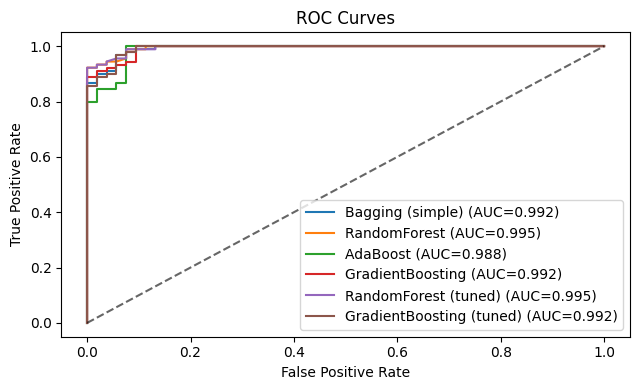

,accuracy,roc_auc
Bagging (simple),0.951049,0.992453
RandomForest,0.958042,0.994864
AdaBoost,0.958042,0.987841
GradientBoosting,0.958042,0.992453
RandomForest (tuned),0.958042,0.994864
GradientBoosting (tuned),0.958042,0.992243


In [7]:
def evaluate_model(name: str, model, X_tr, X_te, y_tr, y_te):
    # predict labels & probabilities
    y_pred = model.predict(X_te)
    # handle predict_proba or decision_function gracefully
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_te)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_te)
        # decision_function can be shape (n_samples,) for binary
        y_proba = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min() + 1e-12)
    else:
        # fallback: hard predictions
        y_proba = y_pred.astype(float)

    acc = accuracy_score(y_te, y_pred)
    try:
        auc = roc_auc_score(y_te, y_proba)
    except Exception:
        auc = np.nan

    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f} | ROC-AUC: {auc:.4f}")
    print("Confusion matrix:\n", confusion_matrix(y_te, y_pred))
    print("Classification report:\n", classification_report(y_te, y_pred, target_names=cancer.target_names))

    # ROC curve
    fpr, tpr, _ = roc_curve(y_te, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
    return acc, auc

plt.figure()
metrics = {}

for lname, mdl in [
    ("Bagging (simple)", bag_simple),
    ("RandomForest", rf),
    ("AdaBoost", ada),
    ("GradientBoosting", gbdt),
    ("RandomForest (tuned)", rf_best),
    ("GradientBoosting (tuned)", gb_best),
]:
    acc, auc = evaluate_model(lname, mdl, X_train, X_test, y_train, y_test)
    metrics[lname] = {"accuracy": acc, "roc_auc": auc}

plt.plot([0, 1], [0, 1], "k--", alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.tight_layout()
plt.show()

pd.DataFrame(metrics).T

In [8]:
# OOB scores (if available)
def get_oob(model, step_name: str):
    try:
        inner = model.named_steps[step_name]
        return getattr(inner, "oob_score_", None)
    except Exception:
        return None

oob_rf = get_oob(rf, "rf")
oob_rf_best = get_oob(rf_best, "rf")

# our simple bagging keeps oob on the estimator inside the pipeline as "bag"
try:
    oob_simple = bag_simple.named_steps["bag"].oob_score_
except Exception:
    oob_simple = None

print("OOB (RandomForest):", oob_rf)
print("OOB (RandomForest tuned):", oob_rf_best)
print("OOB (Simple Bagging):", oob_simple)

OOB (RandomForest): 0.9624413145539906
OOB (RandomForest tuned): 0.9624413145539906
OOB (Simple Bagging): 0.9507042253521126


,importance
worst perimeter,0.145686
worst area,0.144090
worst concave points,0.114607
mean concave points,0.098307
worst radius,0.072351
mean radius,0.060713
mean perimeter,0.055987
mean concavity,0.045211
mean area,0.036753
worst concavity,0.028162


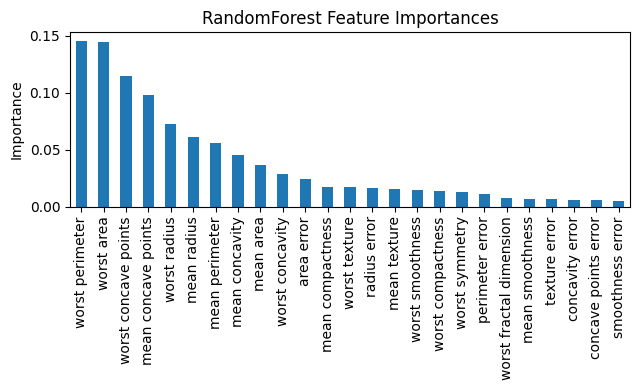

,importance
worst perimeter,0.145696
worst area,0.136844
worst concave points,0.107195
mean concave points,0.103869
worst radius,0.076132
mean perimeter,0.061116
mean radius,0.055198
mean concavity,0.048549
mean area,0.040554
worst concavity,0.029353


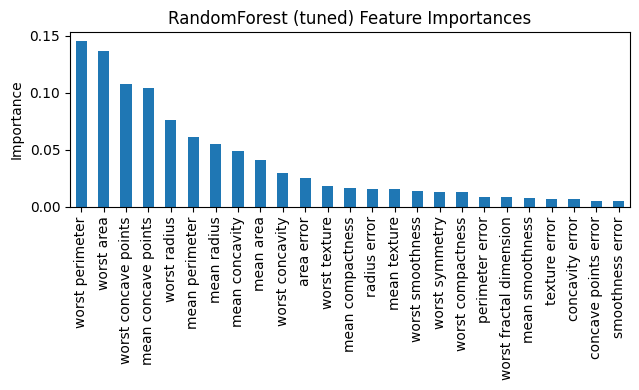

,importance
worst radius,0.558938
worst concave points,0.131888
worst perimeter,0.127710
texture error,0.037132
worst texture,0.032110
worst area,0.031804
mean concave points,0.019703
worst concavity,0.013817
mean texture,0.009075
area error,0.008409


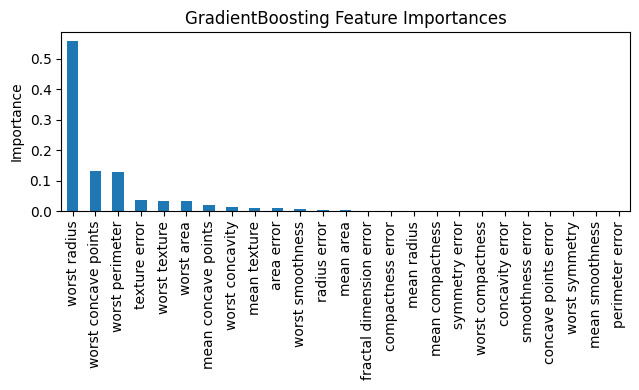

,importance
worst concave points,0.357316
worst radius,0.232633
worst perimeter,0.140090
mean concave points,0.101711
worst area,0.063210
texture error,0.016179
worst texture,0.014988
mean texture,0.013270
concavity error,0.011619
mean perimeter,0.008840


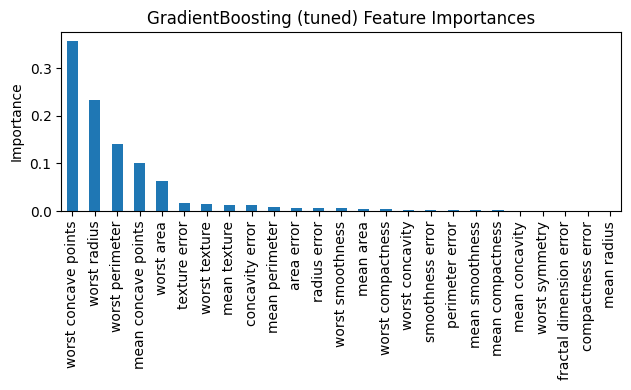

In [9]:
# Feature importances (tree-based models)
def plot_importances(model, step_name: str, feature_names: List[str], title: str):
    try:
        inner = model.named_steps[step_name]
        importances = getattr(inner, "feature_importances_", None)
        if importances is None:
            print(f"No feature_importances_ for {title}")
            return
        imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
        display(imp.to_frame("importance").head(15))
        imp.head(25).plot(kind="bar")
        plt.title(title)
        plt.ylabel("Importance")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not plot importances for {title}:", e)

plot_importances(rf, "rf", list(X.columns), "RandomForest Feature Importances")
plot_importances(rf_best, "rf", list(X.columns), "RandomForest (tuned) Feature Importances")
plot_importances(gbdt, "gb", list(X.columns), "GradientBoosting Feature Importances")
plot_importances(gb_best, "gb", list(X.columns), "GradientBoosting (tuned) Feature Importances")

## Key Takeaways
	•	Bagging reduces variance by averaging many high-variance learners (trees).
	•	Random Forest adds random feature subspacing, further decorrelating trees.
	•	Boosting (AdaBoost/GBDT) reduces bias by building learners sequentially, focusing on mistakes or optimizing a loss.
	•	Tune:
	•	Bagging/RandomForest → n_estimators, max_depth, max_features, min_samples_leaf, bootstrap, oob_score.
	•	AdaBoost → n_estimators, learning_rate, base estimator depth.
	•	GBDT → n_estimators, learning_rate, max_depth (or max_leaf_nodes), min_samples_leaf, subsampling.